# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [1]:
from top2vec import Top2Vec

import os
import spacy
import unidecode
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


2024-08-01 11:49:18.863333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 11:49:19.149925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-01 11:49:19.149944: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-01 11:49:20.146769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

# Data and sources


## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [2]:
liedjesDF = pd.read_csv("../data/liedjes.csv", dtype={'jaartal': 'Int32'})
liedjesDF = liedjesDF.sort_values(by=['songID'])

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    771
Number of booklets:  64


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [3]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.
    
    # create spaCy processor named 'nlp' based on small model for Dutch
    nlp = spacy.load("nl_core_news_sm") 

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(" ".join(new_text)) # add text to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords: list 
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfTexts, replaceDict, removeList):
    result = []
    for liedje in listOfTexts:
        liedje = liedje.lower().split()
        preprocessedLiedje = remove(replace(liedje, replaceDict), removeList)
        result.append(" ".join(preprocessedLiedje))

    return result

We use the above functions to read the lyrics.

In [4]:
liedjesFilenames    = getlistOfFilenames('../data/lyrics')
liedjes             = getlistOfTexts(liedjesFilenames)
lemmatizedLiedjes   = lemmatize(liedjes, select = False)

replaceDict = {"koster":"coster", "kosters":"costers", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "weer", "uw", 
                "waarmee", "immer", "t", "d", "wijze", "hurah", "o"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList)

To investigate whether our code has worked, we look at the data of song with number ```n```.

In [5]:
n = 106

print("-- data: --")
print(liedjesDF.iloc[n])
print("-- path: --")
print(liedjesFilenames[n])
print("-- song: --")
print(liedjes[n])
print("-- lemmatized song: --")
print(lemmatizedLiedjes[n])
print("-- preprocessed song: --")
print(preprocessedLiedjes[n])


-- data: --
typoID                                             amsterdam1849
sourceID                         amsterdam1849-feestliederen1863
songID                        amsterdam1849-feestliederen1863-04
titel                   Hulde en dank aan het werkend gezelschap
wijze                                     Marchand de parapluies
jaartal                                                     1863
schrijver                                        R. van der Star
vereniging_schrijver                               amsterdam1849
Name: 170, dtype: object
-- path: --
../data/lyrics/amsterdam1849/amsterdam1849-feestliederen1863/amsterdam1849-feestliederen1863-04.txt
-- song: --
Hulde en dank aan het werkend gezelschap

Wij vieren thans weder ons jaarlijksche Feest
En doen het als altijd met vrolijken geest.
In vroegeren dagen ,
Kon ’t zoo niet behagen, |
Zoo als het nu heden toch gaat.
Gij Werkende Kring,
Blijft zoo onderling,
Voor Voorzorgs Genoegen steeds waken.
Blijft zoo op den duur,
Met

# Topics with Top2Vec
Do the topics of songs change over time?

In [6]:
model = Top2Vec(liedjes, embedding_model='universal-sentence-encoder-multilingual')
# model = Top2Vec(preprocessedLiedjes)


2024-08-01 11:49:48,039 - top2vec - INFO - Pre-processing documents for training
/home/ivo/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-08-01 11:49:48,613 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2024-08-01 11:50:17.773045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 11:50:19,255 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-08-01 11:50:20.529805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 54179840 exceeds 10% of free system memory.
2024-08-0

In [7]:
model.topic_sizes

0    693
1     28
2     26
3     24
dtype: int64

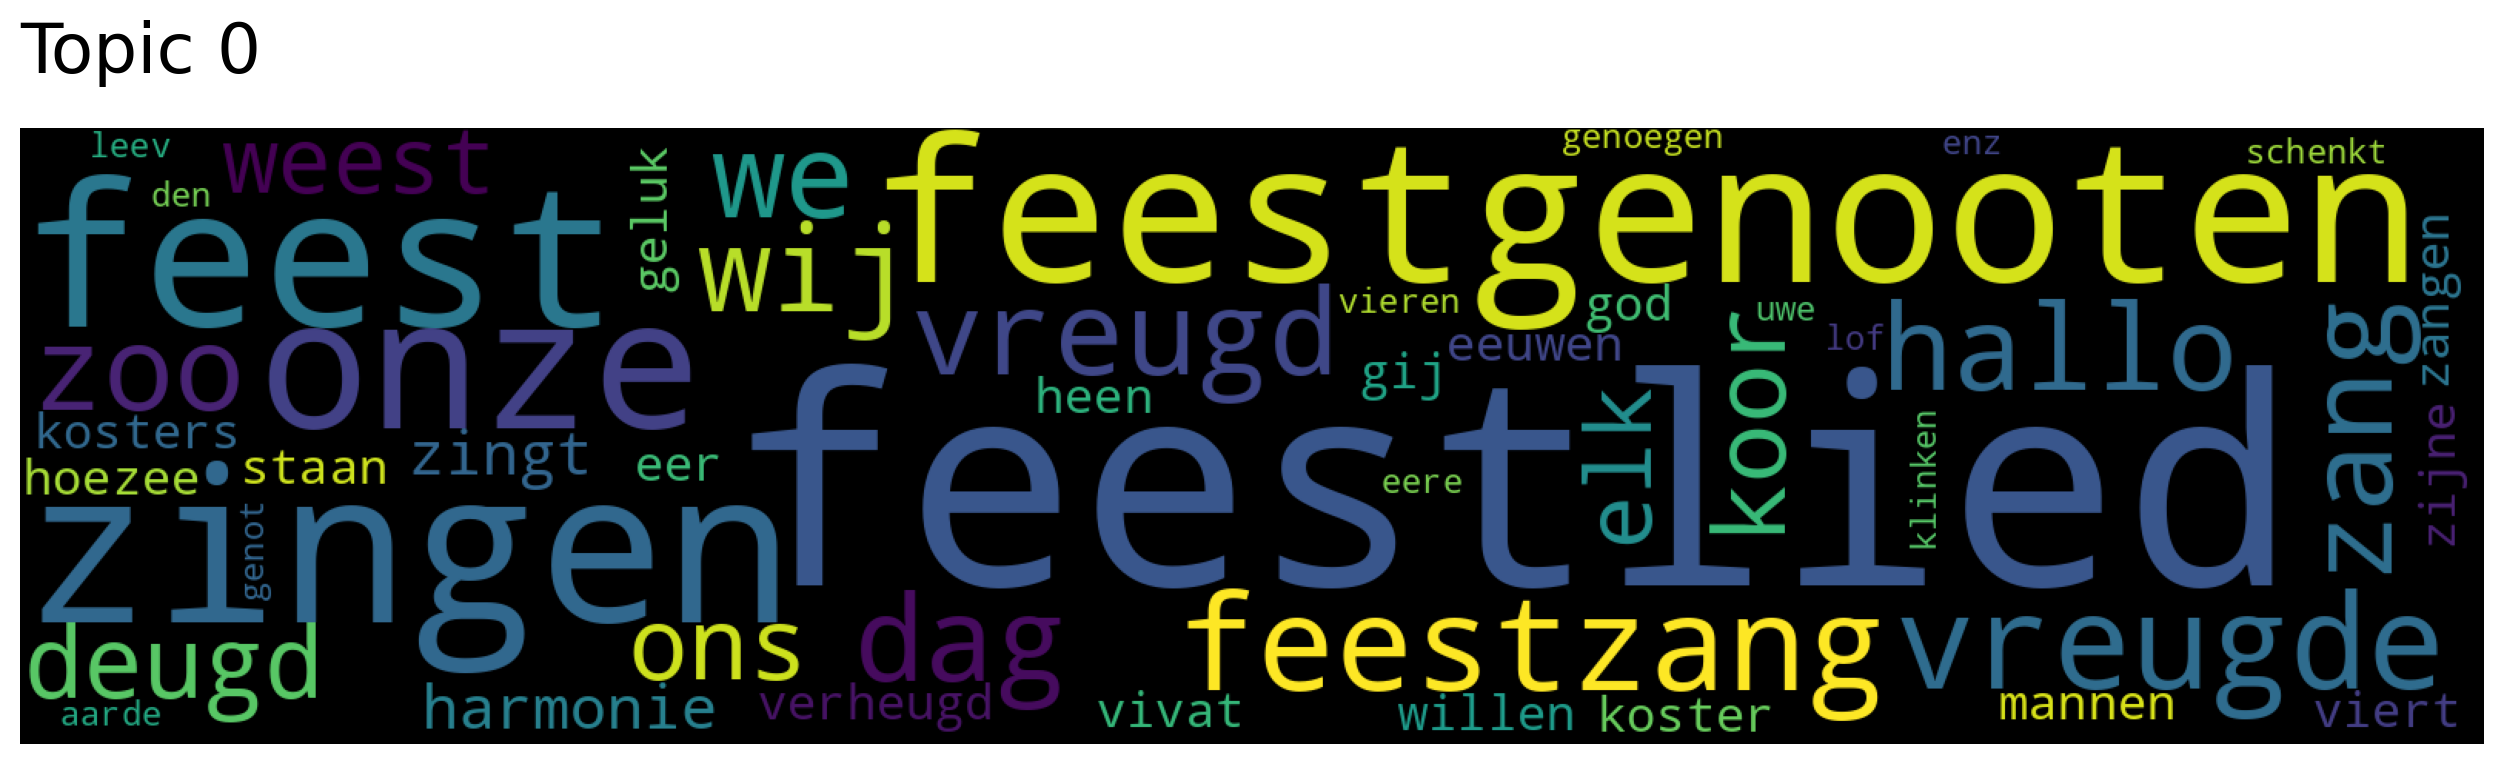

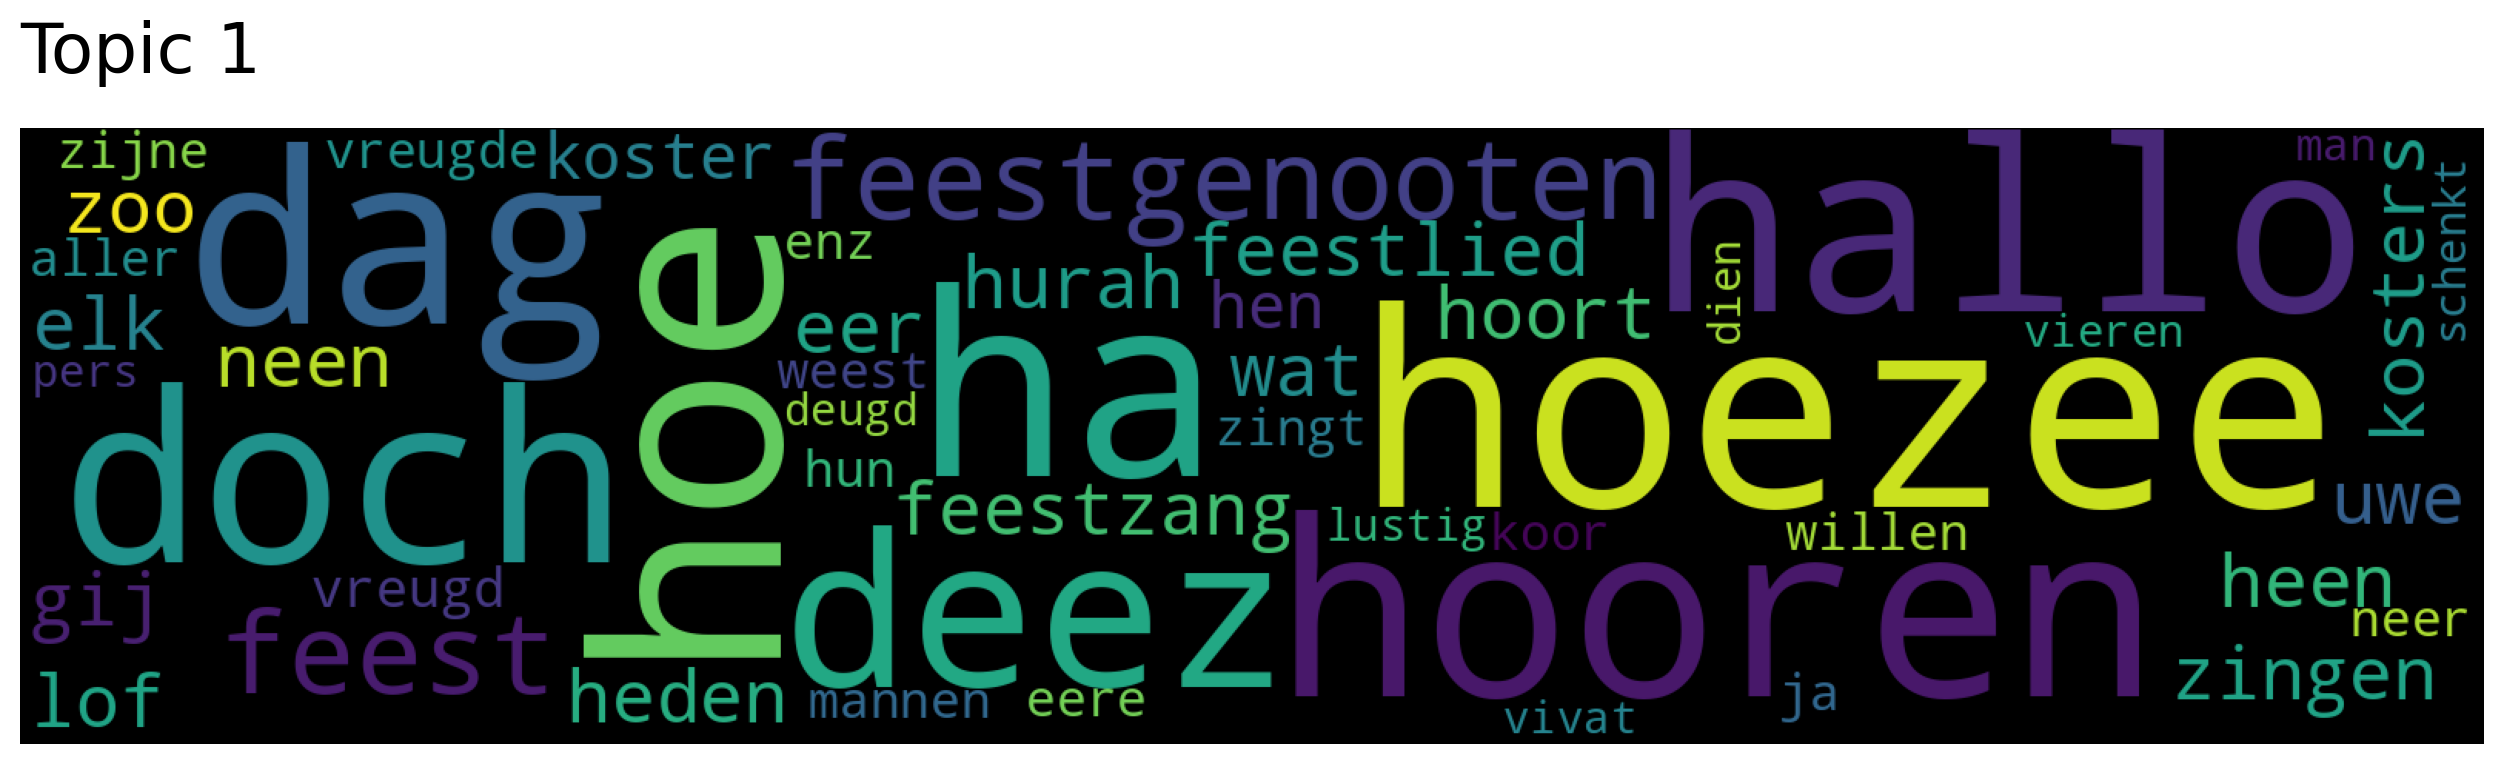

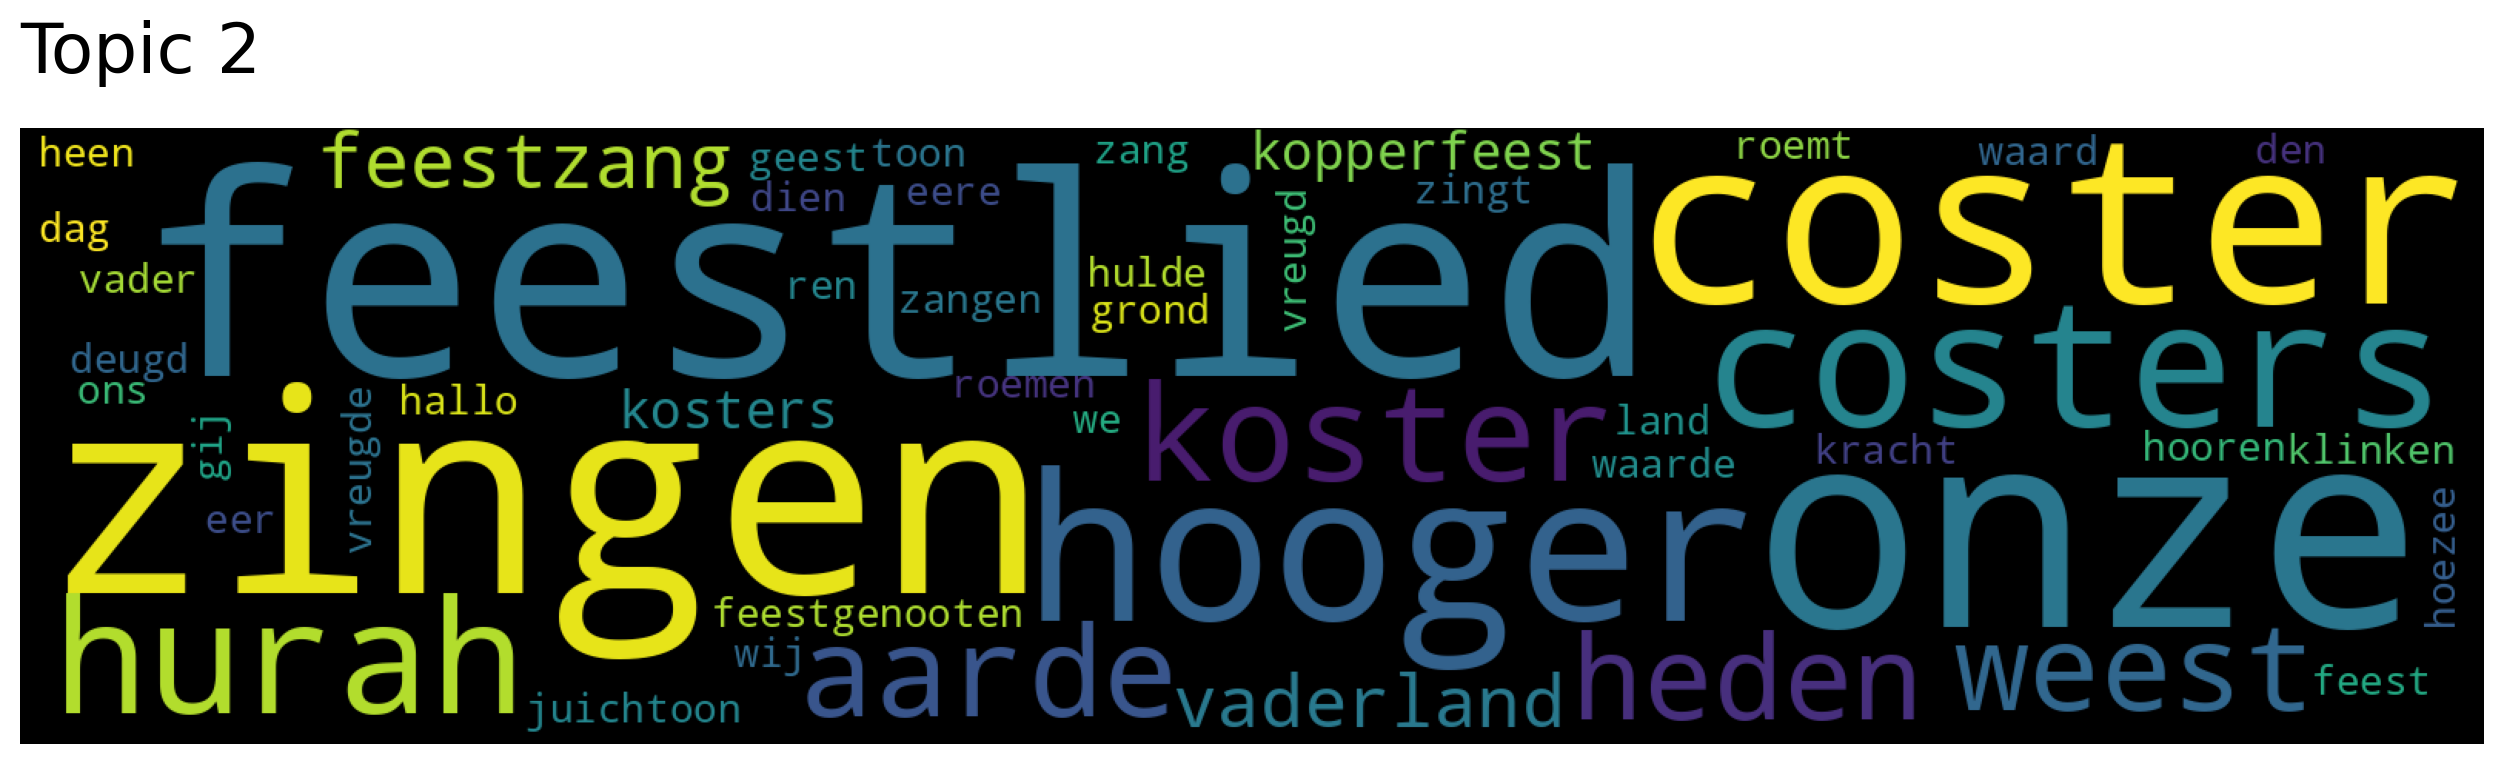

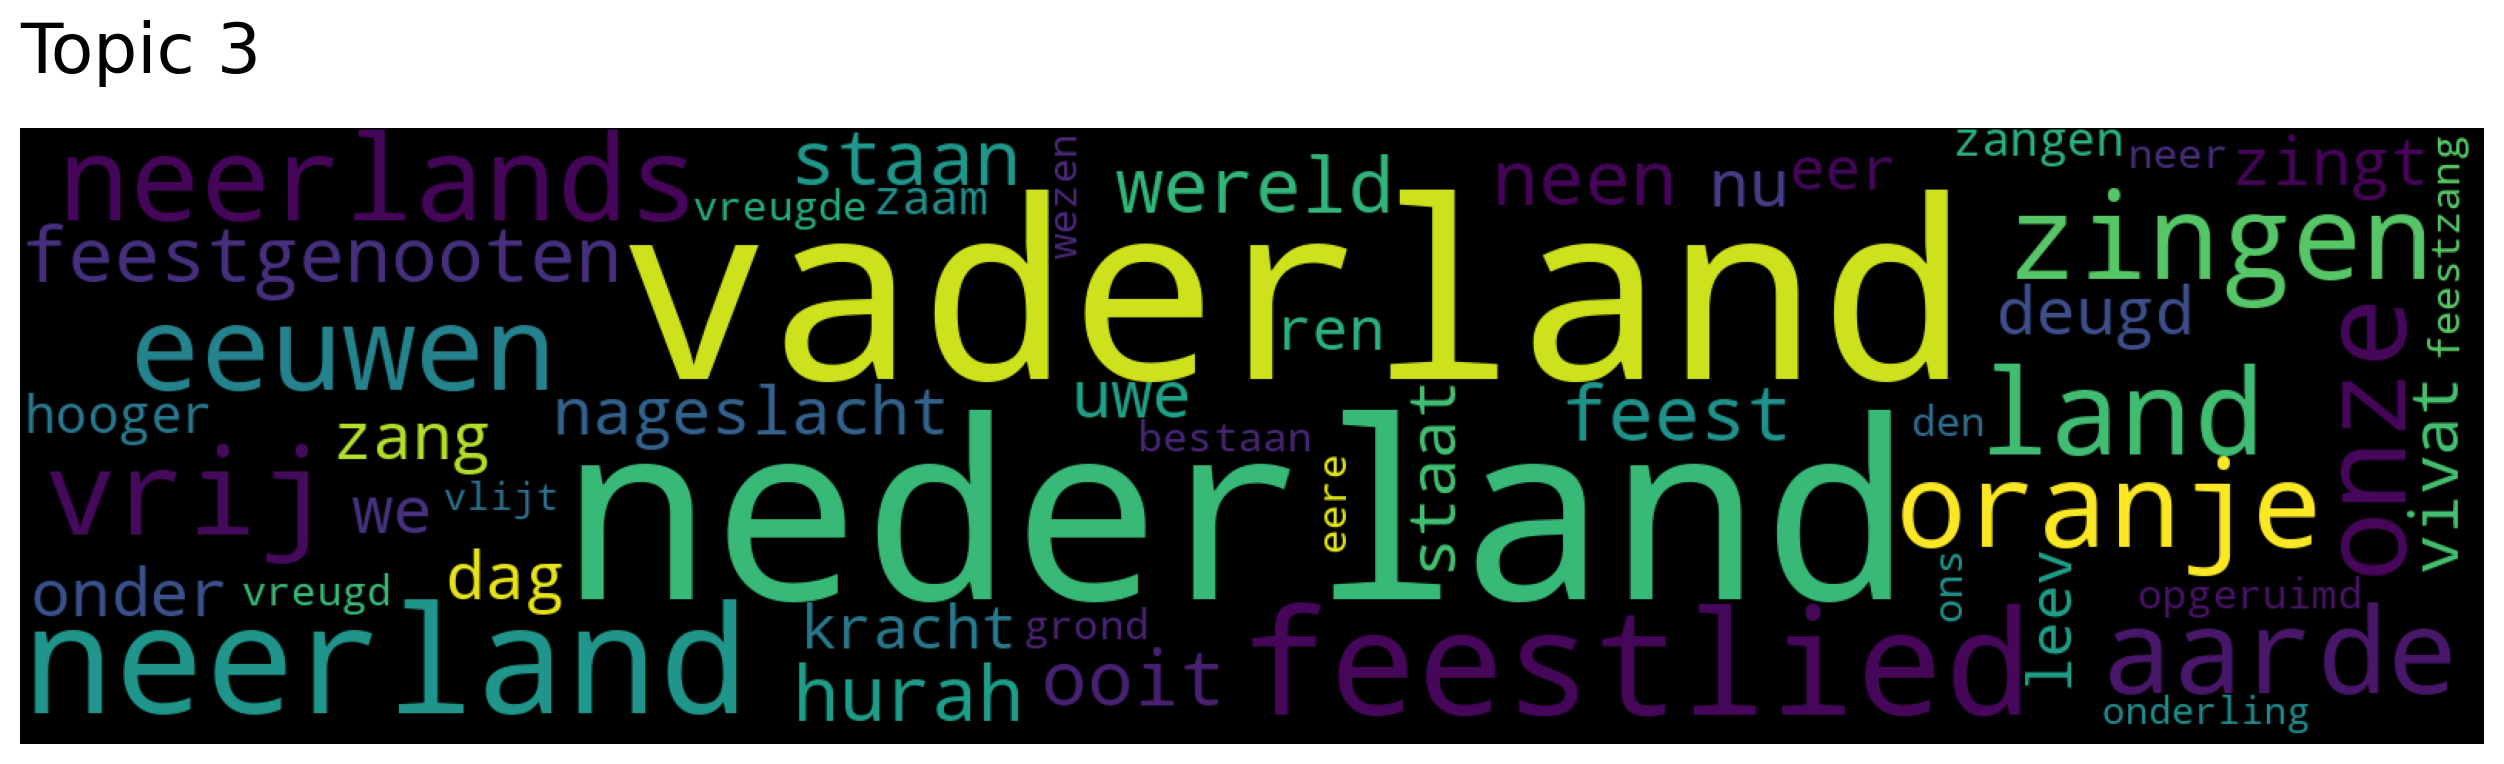

In [8]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [9]:
model.get_documents_topics([8])

(array([0]),
 array([0.47094178], dtype=float32),
 array([['feestlied', 'zingen', 'feestgenooten', 'feest', 'onze',
         'feestzang', 'vreugde', 'vreugd', 'dag', 'hallo', 'we', 'wij',
         'zoo', 'zang', 'deugd', 'ons', 'koor', 'weest', 'elk', 'zingt',
         'harmonie', 'verheugd', 'koster', 'gij', 'kosters', 'geluk',
         'vivat', 'god', 'willen', 'eer', 'staan', 'viert', 'mannen',
         'heen', 'eeuwen', 'zijne', 'zangen', 'hoezee', 'genoegen', 'uwe',
         'eere', 'enz', 'klinken', 'den', 'genot', 'vieren', 'lof',
         'schenkt', 'aarde', 'leev']], dtype='<U13'),
 array([[0.21052319, 0.18972857, 0.16440895, 0.16405845, 0.15304255,
         0.14620617, 0.14035568, 0.1398844 , 0.13941728, 0.13579406,
         0.13100296, 0.12666078, 0.12416911, 0.12151644, 0.11677562,
         0.11361331, 0.11359307, 0.11224185, 0.10713395, 0.10488603,
         0.10402805, 0.10264041, 0.10224554, 0.10216875, 0.10086315,
         0.09927686, 0.09865616, 0.09855165, 0.09714274, 

In [10]:
doc_ids = list(range(0, len(liedjesDF)))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

Text(0.5, 0, 'year')

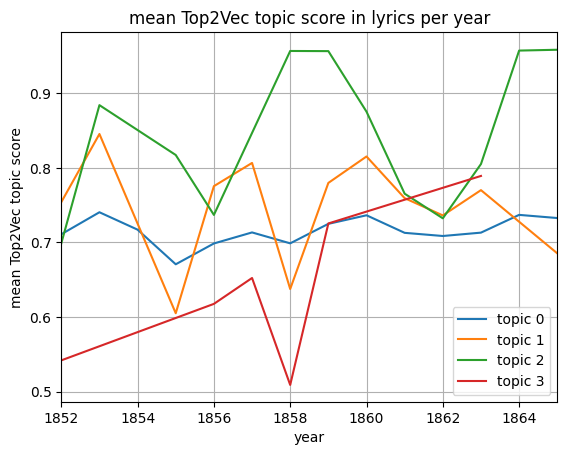

In [19]:
topic_list = topic_nums
# topic_list = [0,3]
for topic in topic_list:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    ax = dfAvg['topic_score'].plot(title="mean Top2Vec topic score in lyrics per year", xlim=(1852,1865), grid=True)

ax.legend(['topic 0', 'topic 1', 'topic 2', 'topic 3'])
ax.set_ylabel('mean Top2Vec topic score')
ax.set_xlabel('year')
